In [7]:
import numpy as np
from sklearn.manifold import TSNE

In [8]:
embeds = np.load('embeds.npy')
embeds = np.squeeze(embeds)

embeds_class = np.load('embed_classes.npy')
embeds_class = np.squeeze(embeds_class)

In [9]:
X_embedded = TSNE(n_components=2).fit_transform(embeds)

/home/user/Nucleus-segmentation/env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


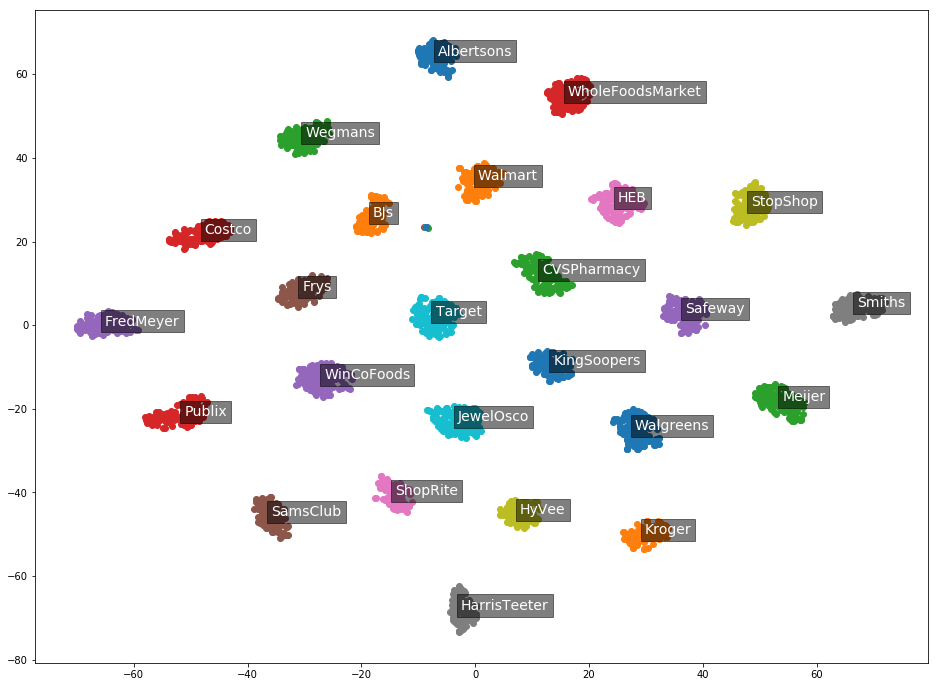

In [22]:
import matplotlib.pyplot as plt
from sklearn import preprocessing

le = preprocessing.LabelEncoder().fit(embeds_class)
colors = le.transform(embeds_class)
labels = le.inverse_transform(range(0,25))

plt.figure(figsize=(16,12))
for i, color in enumerate(np.unique(colors)):
    sub = X_embedded[colors==color]
    plt.scatter(sub[:,0], sub[:,1], label = labels[i])
    plt.text(np.median(sub[:,0]),np.median(sub[:,1]), labels[i], fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.5))
    
# plt.legend(loc='best')
plt.savefig('center_loss.png', bbox_inches='tight')
plt.show()